In [ ]:
#| default_exp clip_plot

In [ ]:
#| hide

%load_ext autoreload
%autoreload 2

# Imports and setup

### Unconditional imports

In [ ]:
#|export

from __future__ import division
import warnings

warnings.filterwarnings("ignore")

In [ ]:
#| export

# print separately that we're loading dependencies, as this can take a while
# and we want to give immediate feedback the program is starting
from clip_plot.utils import timestamp
print(timestamp(), "Beginning to load dependencies")


2023-04-30 19:08:40.722347: Beginning to load dependencies


In [ ]:
#|export

from fastcore.all import *
from tqdm.auto import tqdm

from clip_plot import utils
from clip_plot.utils import clean_filename, get_version, FILE_NAME
from clip_plot.embeddings import get_inception_vectors
from clip_plot.metadata import get_manifest, write_metadata, get_metadata_list

from clip_plot.images import save_image, write_images, Image, get_image_paths, create_atlas_files

In [ ]:
#| export

from shutil import rmtree
from pathlib import Path
from typing import Optional, List, Union, Tuple
import uuid
import sys
import os

### Image processing imports

Note that I have removed the "copy-web-only" conditional import path for now

`nbdev` does not like cells to have cells to have code and imports in the same cell:

https://nbdev.fast.ai/getting_started.html#q-what-is-the-warning-found-a-cell-containing-mix-of-imports-and-computations.-please-use-separate-cells

I think this may mean we don't get to do conditional imports. If we find a code path that really should have conditional imports, we can see if there is a workaround. For now, I don't feel "copy web only" is a very important functionality to keep.

In [ ]:
#| export


import numpy as np
import random
import copy
import json

### Optional install imports

In [ ]:
#| export

DEFAULTS = {
    "images": None,
    "embeds": None,
    "meta_dir": None,
    "out_dir": "output",
    "max_images": None,
    "use_cache": True,
    "encoding": "utf8",
    "cluster_preproc_dims": -1,
    "min_cluster_size": 20,
    "max_clusters": 10,
    "atlas_size": 2048,
    "cell_size": 32,
    "lod_cell_height": 128, # Why is not in parser?
    "n_neighbors": [15],
    "min_dist": [0.01],
    "n_components": 2,
    "metric": "correlation",
    "pointgrid_fill": 0.05,
    "gzip": False,
    "min_size": 100,
    "min_score": 0.3,
    "min_vertices": 18,
    "plot_id": str(uuid.uuid1()),
    "seed": 24,
    "n_clusters": 12,
    "geojson": None,
}

# handle truncated images in PIL (managed by Pillow)
PILLoadTruncated  = True

"""
NB: Keras Image class objects return image.size as w,h
    Numpy array representations of images return image.shape as h,w,c
"""

'\nNB: Keras Image class objects return image.size as w,h\n    Numpy array representations of images return image.shape as h,w,c\n'


## Entry

`process_images` will kick off all the main functions for the module

In [ ]:
#|export

def get_clip_plot_root() -> Path:
    # ipython doesn't have __file__ attribute
    if in_ipython():
        return Path(utils.__file__).parents[1]
    else:
        return Path(__file__).parents[1]

In [ ]:
#| export

def process_images(**kwargs):
    """Main method for processing user images and metadata"""
    kwargs = preprocess_kwargs(**kwargs)

    copy_web_assets(out_dir=kwargs['out_dir'])
    if kwargs["copy_web_only"]:
        print(timestamp(), "Done!")
        sys.exit()
    
    np.random.seed(kwargs["seed"])
    kwargs["out_dir"] = os.path.join(kwargs["out_dir"], "data")
    kwargs["image_paths"], kwargs["metadata"] = filter_images(**kwargs)
    write_metadata(kwargs["metadata"], kwargs["out_dir"], kwargs["gzip"], kwargs["encoding"])
    
    kwargs["atlas_dir"] = create_atlas_files(**kwargs)
    
    kwargs["vecs"] = get_inception_vectors(**kwargs)
    get_manifest(**kwargs)
    write_images(kwargs["image_paths"], kwargs["metadata"], kwargs["out_dir"], kwargs["lod_cell_height"])
    print(timestamp(), "Done!")


def preprocess_kwargs(**kwargs):
    """Preprocess incoming key word arguments
    Converts n_neighbors and min_dist arguments into a list

    Args:
        n_neighbors (int, list[int], default = [15])
        min_dist (int, list[int], default = [0.01])

    Notes:
        Convenient hook for preprocessing arguments
    
    """
    for i in ["n_neighbors", "min_dist"]:
        if not isinstance(kwargs[i], list):
            kwargs[i] = [kwargs[i]]
    return kwargs

In [ ]:
#| export

def copy_web_assets(out_dir: str) -> None:
    """Copy the /web directory from the clipplot source to the users cwd.
    Copies version number into assets.
    
    Args: 
        out_dir (str): directory to copy web assets

    Returns:
        None
    """
    copy_root_dir = get_clip_plot_root()
    src = copy_root_dir / "clip_plot/web"

    # resolve will handle cases with ../ in the path
    dest = Path.cwd() / Path(out_dir).resolve()
    utils.copytree_agnostic(src.as_posix(), dest.as_posix())

    # write version numbers into output
    for i in ["index.html", os.path.join("assets", "js", "tsne.js")]:
        path = os.path.join(dest, i)
        with open(path, "r") as f:
            f = f.read().replace("VERSION_NUMBER", get_version())
            with open(path, "w") as out:
                out.write(f)


In [ ]:
#| export

def filter_images(**kwargs):
    """Main method for filtering images given user metadata (if provided)

    -Validate image:
        Loading (done by stream_images and Images)
        Size
        resizing
        oblong

    -Compare against metadata

    
    Args:
        images (str): Directory location of images.
        out_dir (str): Output directory.
        shuffle (Optional[bool], default = False): Shuffle image order
        seed (int): Seed for random generator
        max_images (Union[bool,int]): Maximum number of images
        atlas_size (int, default = 2048)
        cell_size (int, default = 32)
        lod_cell_height (int, default = 128)
        meta_dir (str): Directory of image metadata

    Returns:
        images (list[str])
        metadata (list[dict])

    Notes:
        Assumes 'filename' is provided in metadata
        Convoluted compiling of metadata
        Should All Validation should belong to Image class?
        Need to split function
    """
    # validate that input image names are unique
        
    print(timestamp(), "Validating input images")
    image_paths = get_image_paths(images=kwargs["images"], out_dir=kwargs["out_dir"])
    image_names = list(map(clean_filename,image_paths))
    duplicates = set([x for x in image_names if image_names.count(x) > 1])

    if duplicates:
        raise Exception(
            """Image filenames should be unique, but the following 
            filenames are duplicated\n{}""".format("\n".join(duplicates)))
    
    # optionally shuffle the image_paths
    if kwargs.get("shuffle", False):
        print(timestamp(), "Shuffling input images")
        random.Random(kwargs["seed"]).shuffle(image_paths)
    else:
        image_paths = sorted(image_paths)

    # Optionally limit the number of images in image_paths
    if kwargs.get("max_images", False):
        image_paths = image_paths[: kwargs["max_images"]]        

    # process and filter the images
    filtered_image_paths = {}
    oblong_ratio = kwargs["atlas_size"] / kwargs["cell_size"]

    for img in tqdm(Image.stream_images(image_paths=image_paths), total=len(image_paths)):
        valid, msg = img.valid(lod_cell_height=kwargs["lod_cell_height"], oblong_ratio=oblong_ratio) 
        if valid is True:
            filtered_image_paths[img.path] = img.filename
        else:
            print(timestamp(), msg)

    # if there are no remaining images, throw an error
    if len(filtered_image_paths) == 0:
        raise Exception("No images were found! Please check your input image glob.")

    # handle the case user provided no metadata
    if not kwargs.get("meta_dir", False):
        return [list(filtered_image_paths.keys()), []]

    # handle user metadata: retain only records with image and metadata
    metaList = get_metadata_list(meta_dir=kwargs['meta_dir'])
    metaDict = {clean_filename(i.get(FILE_NAME, "")): i for i in metaList}
    meta_bn = set(metaDict.keys())
    img_bn = set(filtered_image_paths.values())

    # identify images with metadata and those without metadata
    meta_present = img_bn.intersection(meta_bn)
    meta_missing = list(img_bn - meta_bn)

    # notify the user of images that are missing metadata
    if meta_missing:
        print(
            timestamp(),
            " ! Some images are missing metadata:\n  -",
            "\n  - ".join(meta_missing[:10]),
        )
        if len(meta_missing) > 10:
            print(timestamp(), " ...", len(meta_missing) - 10, "more")

        if os.path.exists(kwargs['out_dir']) is False:
            os.makedirs(kwargs['out_dir'])
            
        missing_dir = os.path.join(kwargs['out_dir'],"missing-metadata.txt")
        with open(missing_dir, "w") as out:
            out.write("\n".join(meta_missing))

    if not meta_present:
        raise Exception( f"""No image has matching metadata. Check if '{FILE_NAME}' key was provided in metadata files""")

    # get the sorted lists of images and metadata
    images = []
    metadata = []
    for path, fileName in filtered_image_paths.items():
        if fileName in meta_present:
            images.append(path)
            metadata.append(copy.deepcopy(metaDict[fileName]))

    return [images, metadata]

## Carlo's Test Functions
# Need to remove later

In [ ]:
#| export

copy_root_dir = get_clip_plot_root()

def test_iiif(config):
    test_images = copy_root_dir/"tests/IIIF_examples/iif_example.txt"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"

    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["plot_id"] = "test_diff"

    return config


def test_butterfly_duplicate(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs_duplicates/**/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()
    config["plot_id"] = "test_diff"

    return config


def test_butterfly(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()
    config["plot_id"] = "test_diff"
    
    config["test_mode"] = True

    return config


def test_butterfly_missing_meta(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/meta_missing_filename.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()
    config["plot_id"] = "test_diff"

    return config


def test_no_meta_dir(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["plot_id"] = "test_diff"

    return config


# Parse the command-line arguments

In [ ]:
#| export

@call_parse
def project_imgs(images:Param(type=str,
                        help="path or glob of images to process"
                        )=DEFAULTS["images"],
                embeds:Param(type=str,
                        help="path or glob of embeddings to process (must match images folder/file structure)"
                        )=DEFAULTS["embeds"],
                metadata:Param(type=str,
                        help="path to a csv or glob of JSON files with image metadata (see readme for format)"
                        )=DEFAULTS["meta_dir"],
                max_images:Param(type=int,
                        help="maximum number of images to process"
                        )=DEFAULTS["max_images"],
                use_cache:Param(type=store_true,
                        help="given inputs identical to prior inputs, load outputs from cache"
                        )=DEFAULTS["use_cache"],
                encoding:Param(type=str,
                        help="the encoding of input metadata"
                        )=DEFAULTS["encoding"],
                cluster_preproc_dims:Param(type=int,
                        help="number of dims to reduce to prior to clustering. -1 means don't reduce",
                        required=False
                        )=DEFAULTS["cluster_preproc_dims"],
                min_cluster_size:Param(type=int,
                        help="the minimum number of images in a cluster",
                        required=False
                        )=DEFAULTS["min_cluster_size"],
                max_clusters:Param(type=int,
                        help="the maximum number of clusters to return",
                        required=False
                        )=DEFAULTS["max_clusters"],
                out_dir:Param(type=str,
                        help="the directory to which outputs will be saved",
                        required=False
                        )=DEFAULTS["out_dir"],
                cell_size:Param(type=int,
                        help="the size of atlas cells in px",
                        required=False
                        )=DEFAULTS["cell_size"],
                n_neighbors:Param(type=int,
                        nargs="+",
                        help="the n_neighbors arguments for UMAP"
                        )=DEFAULTS["n_neighbors"],
                min_dist:Param(type=float,
                        nargs="+",
                        help="the min_dist arguments for UMAP"
                        )=DEFAULTS["min_dist"],
                n_components:Param(type=int,
                        help="the n_components argument for UMAP"
                        )=DEFAULTS["n_components"],
                metric:Param(type=str,
                        help="the metric argument for umap"
                        )=DEFAULTS["metric"],
                pointgrid_fill:Param(type=float,
                        help="float 0:1 that determines sparsity of jittered distributions (lower means more sparse)"
                        )=DEFAULTS["pointgrid_fill"],
                copy_web_only:Param(type=store_true,
                        help="update ./output/assets without reprocessing data"
                        )=False,
                min_size:Param(type=float,
                        help="min size of cropped images"
                        )=DEFAULTS["min_size"],
                gzip:Param(type=store_true,
                        help="save outputs with gzip compression"
                        )=False,
                shuffle:Param(type=store_true,
                        help="shuffle the input images before data processing begins"
                        )=False,
                plot_id:Param(type=str,
                        help="unique id for a plot; useful for resuming processing on a started plot"
                        )=DEFAULTS["plot_id"],
                seed:Param(type=int, help="seed for random processes"
                           )=DEFAULTS["seed"],
                n_clusters:Param(type=int,
                        help="number of clusters if using kmeans"
                        )=DEFAULTS["n_clusters"],
                geojson:Param(type=str,
                        help="path to a GeoJSON file with shapes to be rendered on a map"
                        )=DEFAULTS["geojson"]
                ):
                "Convert a folder of images into a clip-plot visualization"

                # grab local variables as configuration dict
                config = locals()

                # some parameters exist in DEFAULTS but not in the function signature
                default_only_keys = set(set(DEFAULTS.keys() - config.keys()))
                default_only = {k:DEFAULTS[k] for k in default_only_keys}
                config.update(default_only)

                if in_ipython() and config["images"] == None:
                        print("Clip-plot is being run from ipython")
                        # at least for now, this means we're in testing mode.
                        # TODO: pass explicit "test_mode" flag
                        config = test_butterfly(config)
                
                process_images(**config)

Clip-plot is being run from ipython
2023-04-30 19:09:04.149063: Validating input images


  0%|          | 0/12 [00:00<?, ?it/s]

2023-04-30 19:09:05.316717: Creating atlas files


  0%|          | 0/12 [00:00<?, ?it/s]

2023-04-30 19:09:15.190556: Creating Inception vectors


  0%|          | 0/12 [00:00<?, ?it/s]

2023-04-30 19:09:41.404419: Creating single umap layout
2023-04-30 19:09:47.630704: Creating umap pointgrid
2023-04-30 19:09:47.687069: Creating grid layout
2023-04-30 19:09:47.706424: Creating rasterfairy layout
2023-04-30 19:09:48.290421: Coonswarp rectification could not be performed list index out of range
2023-04-30 19:09:48.305418: Creating categorical layout
2023-04-30 19:09:48.429017: Creating date layout
2023-04-30 19:09:48.435601: Creating date layout with 3 columns
2023-04-30 19:09:48.559027: Attempt to create geographic layout
2023-04-30 19:09:48.645427: Creating geographic layout
2023-04-30 19:09:48.672787: Creating custom layout based on xy coordinates in metadata
2023-04-30 19:09:48.680042: Creating custom layout based on xy coordinates in metadata
2023-04-30 19:09:48.687151: Creating custom layout based on xy coordinates in metadata
2023-04-30 19:09:48.694380: Creating custom layout based on xy coordinates in metadata
2023-04-30 19:09:48.701048: Creating custom layout b

  0%|          | 0/12 [00:00<?, ?it/s]

2023-04-30 19:09:51.225666: Done!


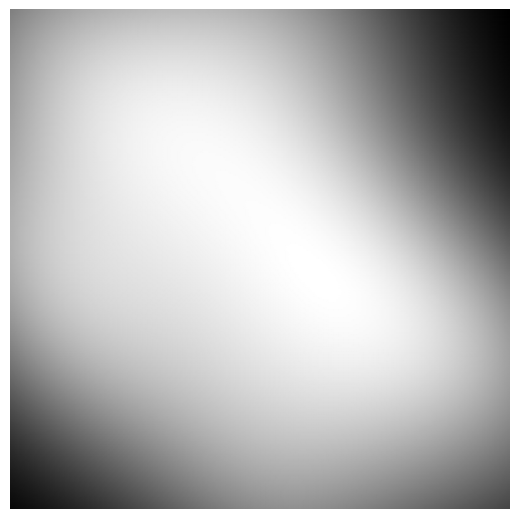

In [ ]:
#| export

if __name__ == "__main__":
    project_imgs()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()